# Bookworm

## Overview

A simple question-answering system built using IBM Watson's NLP services. First use the Discovery service to pre-process a document collection and extract relevant information. Then use the Conversation service to build a natural language interface that can respond to questions.

## Learning Objectives

- Create a cloud-based NLP service instance and configure it.
- Ingest a set of text documents using the service and analyze the results.
- Accept questions in natural language and parse them.
- Find relevant answers from the preprocessed text data.

## Getting Started

In order to use Watson's cloud-based services, we first need to create an account on the [IBM Bluemix platform](https://console.ng.bluemix.net/).

<div>
    <div style="display: table-cell; width: 50%;">
        <img src="images/watson-logo.png" alt="IBM Watson logo" width="200" />
    </div>
    <div style="display: table-cell; width: 50%;">
        <img src="images/bluemix-logo.png" alt="IBM Bluemix logo" width="400" />
    </div>
</div>

## 1. Create and configure Discovery service

Create an instance of the **Discovery** service. We will use this to process a set of text documents, and _discover_ relevant facts and relationships.

- Go to the [IBM Bluemix Catalog](https://console.ng.bluemix.net/catalog/?taxonomyNavigation=services&category=watson).
- Select the service we want, **Discovery**, under the **Watson** category.
- Enter a Service Name for that instance, e.g. **Disco1** and a Credential Name, e.g. **Disco1-Creds** (these are just for us to be able to refer to later, they do not affect the functioning of the service).
- The newly-created service should be in the [Services Dashboard](https://console.ng.bluemix.net/dashboard/services).
- Open the service instance, click on the **Service credentials** tab, and then **View credentials** under Actions. This is where we will find the username and password to use when connecting to the service.

<img src="images/discovery-creds.png" alt="Discovery Service - Credentials tab" width="800" />

Save the credentials for the discovery service in a JSON file in the current directory named `service-credentials.json` with the following format:

```json
{
    "discovery": {
        "username": "",
        "password": ""
    },
    "conversation": {
        "username": "",
        "password": ""
    }
}

```

### Connect to the service instance

Let's connect to the service instance using IBM Watson's [Python SDK](https://github.com/watson-developer-cloud/python-sdk).

In [1]:
# Usual Python imports
import sys
import os
import glob
import json

# BeautifulSoup, for parsing HTML
from bs4 import BeautifulSoup

# Matplotlib, for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Watson Python SDK
import watson_developer_cloud

# Utility functions
import helper

In [2]:
# Connect to the Discovery service instance
discovery_creds = helper.fetch_credentials('discovery')
discovery = watson_developer_cloud.DiscoveryV1(
    version='2016-11-07',
    username=discovery_creds['username'],
    password=discovery_creds['password'])

### Create an environment

The Discovery service organizes everything needed for a particular application in an _environment_. Let's create one called "Bookworm" for this project.

In [3]:
# Prepare an environment to work in
env, env_id = helper.fetch_object(
    discovery, "environment", "Bookworm",
    create=True, create_args=dict(
        description="A space to read and understand stories",
        size=0  # use 0 for free plan (see API reference for more on sizing)
    ))
print(json.dumps(env, indent=2))

Found environment: Bookworm (8960a918-1cdb-4431-815e-ee4249673464)
{
  "environment_id": "8960a918-1cdb-4431-815e-ee4249673464",
  "name": "Bookworm",
  "description": "A space to read and understand stories",
  "created": "2017-06-25T05:53:17.102Z",
  "updated": "2017-06-25T05:53:17.102Z",
  "status": "active",
  "read_only": false,
  "size": 0,
  "index_capacity": {
    "disk_usage": {
      "used_bytes": 0,
      "total_bytes": 4294967296,
      "used": "0 KB",
      "total": "4 GB",
      "percent_used": 0.0
    },
    "memory_usage": {
      "used_bytes": 128502288,
      "total_bytes": 1056309248,
      "used": "122.55 MB",
      "total": "1007.38 MB",
      "percent_used": 12.17
    }
  }
}


### Verify configuration options

A _configuration_ defines what natural language processing routines are applied to any documents that are submitted to the service. Each environment gets a default configuration when it is created.

In [4]:
# View default configuration
cfg_id = discovery.get_default_configuration_id(environment_id=env_id)
cfg = discovery.get_configuration(environment_id=env_id, configuration_id=cfg_id)
print(json.dumps(cfg, indent=2))

{
  "configuration_id": "b8b7d5d7-ea7c-4d1e-831a-2997fcefcb66",
  "name": "Default Configuration",
  "description": "The configuration used by default when creating a new collection without specifying a configuration_id.",
  "created": "2017-06-25T05:53:17.139Z",
  "updated": "2017-06-25T05:53:17.139Z",
  "conversions": {
    "word": {
      "heading": {
        "fonts": [
          {
            "level": 1,
            "min_size": 24,
            "bold": false,
            "italic": false
          },
          {
            "level": 2,
            "min_size": 18,
            "max_size": 23,
            "bold": true,
            "italic": false
          },
          {
            "level": 3,
            "min_size": 14,
            "max_size": 17,
            "bold": false,
            "italic": false
          },
          {
            "level": 4,
            "min_size": 13,
            "max_size": 13,
            "bold": true,
            "italic": false
          }
        ],
    

There are 3 main configuration blocks that affect how input documents are processed:
 
1. **`conversions`**: How to convert documents in various formats (Word, PDF, HTML) and extract elements that indicate some structure (e.g. headings).
2. **`enrichments`**: What NLP output results are we interested in (keywords, entities, sentiment, etc.).
3. **`normalizations`**: Post-processing steps to be applied to the output. This can be left empty in most cases, unless we need the output to be normalized into a very specific format.

_**Note**: The default configuration for an environment cannot be modified. If we need to change any of the options, we will need to create a new one, and then edit it. The easiest way to do this is using the service dashboard, which is described later._

### Test the configuration

It is a good idea to test the configuration on a small sample text before applying it to a larger document collection.

- `data/sample.html` contains the opening crawl text for Star Wars: Episode IV.

In [5]:
# Test configuration on some sample text
data_dir = "data"
filename = os.path.join(data_dir, "sample.html")
with open(filename, "r") as f:
    res = discovery.test_document(environment_id=env_id, configuration_id=cfg_id, fileinfo=f)
print(json.dumps(res, indent=2))

{
  "status": "completed",
  "enriched_field_units": 1,
  "original_media_type": "text/html",
  "snapshots": [
    {
      "step": "html_input",
      "snapshot": {
        "html": "<html>\n<head>\n    <title>Star Wars: Episode IV - A New Hope (Opening Crawl)</title>\n</head>\n<body>\n    <article>\n        <h1>Star Wars: Episode IV - A New Hope (Opening Crawl)</h1>\n        <p>\n            It is a period of civil war. Rebel spaceships, striking from a hidden base, have won their first victory against the evil Galactic Empire.\n        </p><p>\n            During the battle, Rebel spies managed to steal secret plans to the Empire's ultimate weapon, the DEATH STAR, an armored space station with enough power to destroy an entire planet.\n        </p><p>\n            Pursued by the Empire's sinister agents, Princess Leia races home aboard her starship, custodian of the stolen plans that can save her people and restore freedom to the galaxy...\n        </p>\n    </article>\n</body>"
     

### Analyze test output

The results returned by the service contain a _snapshot_ of the information extracted at each step of processing - document conversions, enrichments and normalizations. We are interested in the output of applying enrichments (`"enrichments_output"`) or after normalizing them (`"normalizations_output"`). These should be identical if no post-processing/normalizations were specified in the configuration.

In [6]:
# Take a closer look at the results from the "enrichments_output" or "normalizations_output" step
output = next((s["snapshot"] for s in res["snapshots"] if s["step"] == "enrichments_output"), None)
print(json.dumps(output, indent=2))

{
  "extracted_metadata": {
    "title": "Star Wars: Episode IV - A New Hope (Opening Crawl)"
  },
  "html": "<?xml version='1.0' encoding='UTF-8' standalone='yes'?><html>\n<head>\n    <meta content=\"text/html; charset=UTF-8\" http-equiv=\"Content-Type\"/>\n    \n    <title>Star Wars: Episode IV - A New Hope (Opening Crawl)</title>\n\n\n</head>\n<body>\n\n\n    <article>\n        <h1>Star Wars: Episode IV - A New Hope (Opening Crawl)</h1>\n        <p>\n            It is a period of civil war. Rebel spaceships, striking from a hidden base, have won their first victory against the evil Galactic Empire.\n        </p><p>\n            During the battle, Rebel spies managed to steal secret plans to the Empire's ultimate weapon, the DEATH STAR, an armored space station with enough power to destroy an entire planet.\n        </p><p>\n            Pursued by the Empire's sinister agents, Princess Leia races home aboard her starship, custodian of the stolen plans that can save her people and res

### Questions

#### Sentiment

**Q**: What is the overall sentiment detected in this text?

**A**: "type": "negative", "score": -0.575489.


#### Concepts

**Q**: List 3 concepts that have been identified with a relevance > 0.5. Note that not all concepts here may be present directly in the text, some may have been inferred by Watson.

**A**:
* "text": "Star Wars Episode IV: A New Hope", "relevance": 0.98887
* "text": "Star Wars", "relevance": 0.985705
* "text": "Rebel Alliance", "relevance": 0.90639


#### Relations

Each relation is essentially a deeper analysis of a sentence (or part of a sentence). Here is a sample relation:

```json
{
  "sentence": " During the battle, Rebel spies managed to steal secret plans to the Empire's ultimate weapon, the DEATH STAR, an armored space station with enough power to destroy an entire planet.",
  "subject": {
    "text": "Rebel spies",
    "keywords": [
      {
        "text": "Rebel spies"
      }
    ]
  },
  "action": {
    "text": "managed to steal",
    "lemmatized": "manage to steal",
    "verb": {
      "text": "steal",
      "tense": "future"
    }
  },
  "object": {
    "text": "secret plans",
    "keywords": [
      {
        "text": "secret plans"
      }
    ]
  }
 }
```

In this case, Watson seems to have done a pretty good job of extracting some meaning from the sentence.

**Q**: Find a relation where the extracted meaning is not as accurate. List the `sentence`, `subject`, `action` and `object` parts as identified, and what you would've marked instead.

**A**:
```json
{
  "sentence": " Pursued by the Empire's sinister agents, Princess Leia races home aboard her starship, custodian of the stolen plans that can save her people and restore freedom to the galaxy...",
  "subject": {
    "text": "by the Empire", // Princess Leia
    "keywords": [
      {
        "text": "Empire" 
      }
    ]
  },
  "action": {
    "text": "Pursued", // aboard
    "lemmatized": "Pursued",
    "verb": {
      "text": "Pursued",
      "tense": "past"
    }
  },
  "object": {
    "text": "Princess Leia", // starship
    "keywords": [
      {
        "text": "Princess Leia"
      }
    ]
  }
}
```


#### Keywords

Watson identifies some `"keywords"` in the relations, e.g. `"Rebel spies"` and `"secret plans"` in the Star Wars example above. The output also contains a list of all keywords at the top level, along with their relevance to the document and sentiment conveyed. Let's visualize these keywords as a word cloud! ([worldcoud library](https://github.com/amueller/word_cloud))

/Users/luli/miniconda3/envs/dlnd/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The Vega10 colormap was deprecated in version 2.0. Use tab10 instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(-0.5, 799.5, 599.5, -0.5)

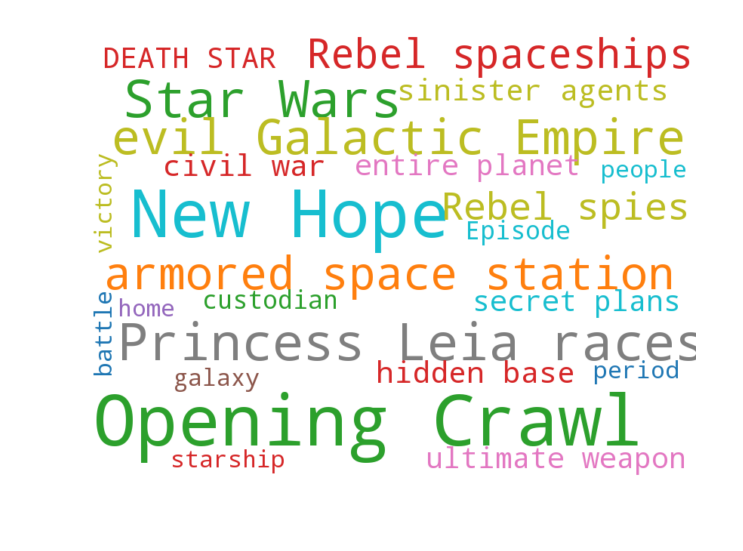

In [7]:
# Visualize keywords by relevance as a wordcloud
from wordcloud import WordCloud

wc_data = { w["text"]: w["relevance"] for w in output["enriched_text"]["keywords"] }
wc = WordCloud(width=400, height=300, scale=2, background_color="white", colormap="Vega10")
wc.generate_from_frequencies(wc_data)  # use precomputed relevance instead of frequencies

plt.figure(figsize=(4, 3), dpi=200)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

#### Other results

Watson's output also includes processed results from other enrichments that were applied to the text, including entities and taxonomy (what topic or category does this text relate to).

```json
"taxonomy": [
  {
    "label": "/art and entertainment/movies and tv/movies",
    "score": 0.584247,
    "confident": false
  },
  {
    "label": "/society/unrest and war",
    "score": 0.517031,
    "confident": false
  },
  {
    "confident": false,
    "label": "/law, govt and politics/armed forces/army",
    "score": 0.215561
  }
],
```

## 2. Ingest documents

### Create a collection

A _collection_ is used to organize documents of the same kind. For instance, we may want to create a collection of book reviews, or a collection of Wikipedia articles, but it may not make much sense to mix the two groups. This allows Watson to make meaningful inferences over the set of documents, find commonalities and identify important concepts.

Let's create one called "Story Chunks".

In [8]:
# Prepare a collection of documents to use
col, col_id = helper.fetch_object(discovery, "collection", "Story Chunks", environment_id=env_id,
    create=True, create_args=dict(
        environment_id=env_id, configuration_id=cfg_id,
        description="Stories and plots split up into chunks suitable for answering"
    ))
print(json.dumps(col, indent=2))

Created collection: Story Chunks (3b77e646-2460-426c-be06-968b896bcca1)
{
  "name": "Story Chunks",
  "collection_id": "3b77e646-2460-426c-be06-968b896bcca1",
  "description": "Stories and plots split up into chunks suitable for answering",
  "created": "2017-06-26T18:16:02.410Z",
  "updated": "2017-06-26T18:16:02.410Z",
  "configuration_id": "b8b7d5d7-ea7c-4d1e-831a-2997fcefcb66",
  "language": "en",
  "status": "active"
}


Once the collection has been created, we can view it using the Discovery Service tool. To open, go to the **Manage** tab for the service instance, and click the **Launch tool** button.

<img src="images/discovery-manage.png" alt="Discovery service - Manage tab" width="800" />


Here we should see the "Story Chunks" collection:

<img src="images/discovery-tooling.png" alt="Discovery service - Tool showing collections" width="800" />

Open the collection to view more details about it. Click the **Switch** link and create a new configuration (the default one cannot be changed) to modify configuration options.

### Add documents

Okay, now that we have everything set up, let's add a set of "documents" we want Watson to look up answers from, using the Python SDK. Note that Watson treats each "document" as a unit of text that is returned as the result of a query. But we want to retrieve a paragraph of text for each question. So, let's split each file up into individual paragraphs. We will use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library for this purpose.

* add and manage documents in the collection using the Discovery tool requires split paragraphs up into separate files
* `data/Star-Wars/*.html` contains a set of files with summary plots for Star Wars movies. Open one of the files in a text editor to see how the paragraphs are delimited using `<p>...</p>` tags - this is how the code block below split paragraphs into separate "documents".

In [9]:
# Add documents to collection
doc_ids = []  # to store the generated id for each document added
for filename in glob.glob(os.path.join(data_dir, "Star-Wars", "*.html")):
    print("Adding file:", filename)
    with open(filename, "r") as f:
        # Split each individual <p> into its own "document"
        doc = f.read()
        soup = BeautifulSoup(doc, 'html.parser')
        for i, p in enumerate(soup.find_all('p')):
            doc_info = discovery.add_document(environment_id=env_id, collection_id=col_id,
                file_data=json.dumps({"text": p.get_text(strip=True)}),
                mime_type="application/json",
                metadata={"title": soup.title.get_text(strip=True)})
            doc_ids.append(doc_info["document_id"])
print("Total", len(doc_ids), "documents added.")

Adding file: data/Star-Wars/Episode-I_The-Phantom-Menace.html
Adding file: data/Star-Wars/Episode-II_Attack-of-the-Clones.html
Adding file: data/Star-Wars/Episode-III_Revenge-of-the-Sith.html
Adding file: data/Star-Wars/Episode-IV_A-New-Hope.html
Adding file: data/Star-Wars/Episode-V_The-Empire-Strikes-Back.html
Adding file: data/Star-Wars/Episode-VI_Return-of-the-Jedi.html
Adding file: data/Star-Wars/Episode-VII_The-Force-Awakens.html
Adding file: data/Star-Wars/Rogue-One.html
Total 42 documents added.


In [10]:
# View collection details to verify all documents have been processed
col, col_id = helper.fetch_object(discovery, "collection", "Story Chunks", environment_id=env_id)
print(json.dumps(col, indent=2))

Found collection: Story Chunks (3b77e646-2460-426c-be06-968b896bcca1)
{
  "collection_id": "3b77e646-2460-426c-be06-968b896bcca1",
  "name": "Story Chunks",
  "configuration_id": "b8b7d5d7-ea7c-4d1e-831a-2997fcefcb66",
  "language": "en",
  "status": "active",
  "description": "Stories and plots split up into chunks suitable for answering",
  "created": "2017-06-26T18:16:02.410Z",
  "updated": "2017-06-26T18:16:02.410Z",
  "document_counts": {
    "available": 42,
    "processing": 0,
    "failed": 0
  },
  "training_status": {
    "data_updated": "",
    "total_examples": 0,
    "sufficient_label_diversity": false,
    "processing": false,
    "minimum_examples_added": false,
    "successfully_trained": "",
    "available": false,
    "notices": 0,
    "minimum_queries_added": false
  }
}


So, what did the Discovery service learn?

In [11]:
# List all fields extracted
discovery.list_collection_fields(environment_id=env_id, collection_id=col_id)

{'fields': [{'field': '3b77e646-2460-426c-be06-968b896bcca1.mappings.document._all.analyzer',
   'type': 'english'},
  {'field': 'enriched_text', 'type': 'nested'},
  {'field': 'extracted_metadata', 'type': 'nested'},
  {'field': 'metadata', 'type': 'nested'},
  {'field': 'text', 'type': 'string'},
  {'field': 'text.analyzer', 'type': 'english'},
  {'field': 'enriched_text.properties.concepts', 'type': 'nested'},
  {'field': 'enriched_text.properties.docSentiment', 'type': 'nested'},
  {'field': 'enriched_text.properties.entities', 'type': 'nested'},
  {'field': 'enriched_text.properties.keywords', 'type': 'nested'},
  {'field': 'enriched_text.properties.language', 'type': 'string'},
  {'field': 'enriched_text.properties.language.analyzer', 'type': 'english'},
  {'field': 'enriched_text.properties.relations', 'type': 'nested'},
  {'field': 'enriched_text.properties.status', 'type': 'string'},
  {'field': 'enriched_text.properties.status.analyzer', 'type': 'english'},
  {'field': 'enric

### Test query

Let's perform a simple query to see if the service can fetch the proper document for us.

In [12]:
# A simple query: look for all paragraphs that have a relation (sentence) with "Jar Jar" 
# as the subject, and return the title and text.
results = discovery.query(environment_id=env_id, collection_id=col_id,
    query_options={
        "query": "enriched_text.relations.subject.text:\"Jar Jar\"",
        "return": "metadata.title,text"
    })
print(json.dumps(results, indent=2))

{
  "matching_results": 2,
  "results": [
    {
      "id": "867383e5-bbdd-4eb2-b4b9-c8b322fcc46c",
      "score": 2.9906685,
      "metadata": {
        "title": "Star Wars: Episode I - The Phantom Menace"
      },
      "text": "Supreme Chancellor Valorum, leader of the Galactic Republic, dispatches Jedi Knight Qui-Gon Jinn and his apprentice, Obi-Wan Kenobi, to negotiate with the Trade Federation leadership to end a blockade of battleships around the planet Naboo. Darth Sidious, a Sith Lord and the Trade Federation's secret adviser, orders Federation Viceroy Nute Gunray to kill the Jedi and invade Naboo with an army of battle droids. The Jedi escape and flee to Naboo, where Qui-Gon saves a Gungan outcast, Jar Jar Binks, from being run over and killed by a droid tank during the invasion. Indebted to the Jedi, Jar Jar leads them to an underwater Gungan city. The Jedi unsuccessfully try to persuade the Gungan leader, Boss Nass, into helping the people of Naboo, though they are able to 

In [29]:
# Try another one
results = discovery.query(environment_id=env_id, collection_id=col_id,
    query_options={
        "query": "enriched_text.concepts::(relevance>0.95,text:\"Rebel Alliance\")",
        "return": "metadata.title,text"
    })
print(json.dumps(results, indent=2))

{
  "matching_results": 3,
  "results": [
    {
      "id": "7fcf5266-adfa-424b-a9a6-29fd9e4e96a9",
      "score": 7.2352724,
      "metadata": {
        "title": "Star Wars: Episode VII - The Force Awakens"
      },
      "text": "Three decades after the destruction of the second Death Star, the First Order has risen from the fallen Galactic Empire and seeks to eliminate the New Republic. The Resistance, backed by the Republic and led by General Leia Organa, opposes them while searching for her brother, Luke Skywalker, to enlist his aid."
    },
    {
      "id": "bc72c02e-481e-47ce-8e1d-27aeaccf0a11",
      "score": 7.2352724,
      "metadata": {
        "title": "Star Wars: Rogue One"
      },
      "text": "Krennic corners Jyn, declaring the Empire's victory, but Cassian, who has survived, shoots and wounds Krennic. Jyn transmits the schematics to the Rebel command ship. The Death Star enters orbit above Scarif, where Tarkin uses another low-power shot from the superlaser to destro

**Q**: What query did you try?

**A**: Return only the documents that contain the concept "Rebel Alliance" with a relevance score above 95% for that concept.

**Q**: What answer did you get back from Watson? 

**A**: See above.

## 3. Parse natural language questions

In order to understand questions posed in natural language, we'll use another Watson service called [Conversation](https://www.ibm.com/watson/developercloud/doc/conversation/index.html). It can be used to design conversational agents or _chatbots_ that exhibit complex behavior, but for the purpose of this project, we'll only use it to parse certain kinds of queries.


### Create a Conversation service instance

Create an instance of the Conversation service then launch the associated tool from the service dashboard.

<img src="images/conversation-tooling.png" alt="Conversation service - Tool homepage" width="800" />

A _workspace_ allows us to keep all the items we need for a particular application in one place, just like an _environment_ in case of the Discovery service. Create one called "Bookworm" with a suitable description, such as "I know a lot of stories. Ask me a question!"

<img src="images/conversation-workspace.png" alt="Conversation service - Blank workspace" width="800" />

This should open up a blank workspace, where we can add intents, define the entities you want the agent to idenitfy and structure the overall dialog.


### Add intents

An _intent_ is the goal or purpose of a user's input. Create a set of intents that capture the different kinds of questions that we want the system to answer, e.g. _who_, _what_ and _where_. Along with each intent, add a list of user examples or _utterances_ that map to that intent.

The Conversation service recommends at least 5 examples for each intent so that Watson learns how to recognize it. These don't have to be very precise, but more examples the better.

<img src="images/conversation-intents.png" alt="Conversation service - Intents listed" width="800" />

> See [**Defining intents**](https://www.ibm.com/watson/developercloud/doc/conversation/intents.html) for a helpful video and further instructions.

**Q**: What intents did you add to the Conversation service instance?

**A**: who, what and where.


**Q**: Pick one of these intents, and list at least 5 examples for the intent that you entered.

**A**: "who" - 
* Who killed the Emperor?
* Who's Luke's father?
* Who tells Luke, "Join me and I will complete your training"?
* Who was Supreme Chancellor before Palpatine?
* Who was the final rescuer to enter Jabba's palace?


### Add entities

Once the intents are set, let's tell the service what entities we want it to identify. One way to do this is using the tool interface, and entering them one-by-one.

> Go to [**Defining entities**](https://www.ibm.com/watson/developercloud/doc/conversation/entities.html) to see how that is done.

But that can be tedious! So let's refer back to the entities that the Discovery service identified, and load them in programmatically.

As before, let's connect to the Conversation service first.

In [30]:
# Connect to the Conversation service instance
conversation_creds = helper.fetch_credentials('conversation')
conversation = watson_developer_cloud.ConversationV1(
    version='2017-02-03',
    username=conversation_creds['username'],
    password=conversation_creds['password'])

Fetch the workspace just created called "Bookworm".

In [31]:
wrk, wrk_id = helper.fetch_object(conversation, "workspace", "Bookworm")
print(json.dumps(wrk, indent=2))

Found workspace: Bookworm (2dea82ae-3319-46e0-9f0b-e1ee322dc8a5)
{
  "name": "Bookworm",
  "created": "2017-06-26T20:20:25.867Z",
  "updated": "2017-06-26T20:49:13.182Z",
  "language": "en",
  "metadata": null,
  "description": "I know a lot of stories. Ask me a question!",
  "workspace_id": "2dea82ae-3319-46e0-9f0b-e1ee322dc8a5",
  "status": "Available"
}


Collect all the entities from the Discovery service collection.

In [32]:
# Get all the entities from the collection and group them by type
response = discovery.query(environment_id=env_id, collection_id=col_id,
    query_options={
        "return": "enriched_text.entities.type,enriched_text.entities.text"
    })

# Group individual entities by type ("Person", "Location", etc.)
entities_by_type = {}
for document in response["results"]:
    for entity in document["enriched_text"]["entities"]:
        if entity["type"] not in entities_by_type:
            entities_by_type[entity["type"]] = set()
        entities_by_type[entity["type"]].add(entity["text"])

# Ignore case to avoid duplicates
for entity_type in entities_by_type:
    entities_by_type[entity_type] = {
        e.lower(): e for e in entities_by_type[entity_type]
    }.values()

# Restructure for loading into Conversation workspace
entities_grouped = [{
    "entity": entity_type,
    "values": [{"value": entity} for entity in entities]}
        for entity_type, entities in entities_by_type.items()]
entities_grouped


[{'entity': 'Organization',
  'values': [{'value': 'Galactic Republic'},
   {'value': 'Jedi Council'},
   {'value': 'droid army'},
   {'value': 'Trade Federation'},
   {'value': 'Tusken Raiders'},
   {'value': 'Senate'},
   {'value': 'Force'},
   {'value': 'Rebel Alliance'},
   {'value': 'Galactic Senate'},
   {'value': 'Federation'}]},
 {'entity': 'Person',
  'values': [{'value': 'Padmé'},
   {'value': 'Boba'},
   {'value': 'Shmi'},
   {'value': 'Anakin'},
   {'value': 'Luke'},
   {'value': 'Senator Padmé Amidala'},
   {'value': 'Anakin Skywalker'},
   {'value': 'Obi-Wan'},
   {'value': 'Boss Nass'},
   {'value': 'Amidala'},
   {'value': 'Jango Fett'},
   {'value': 'Owen'},
   {'value': 'Gunray'},
   {'value': 'Organa'},
   {'value': 'Beru Lars'},
   {'value': 'Darth Sidious'},
   {'value': 'Darth Vader'},
   {'value': 'Mace Windu'},
   {'value': 'Senator Palpatine'},
   {'value': 'Luke Skywalker'},
   {'value': 'Cliegg Lars'},
   {'value': 'Princess Leia'},
   {'value': 'Watto'},
   

Update the workspace with these entities and verify that have been added correctly.

In [33]:
# Add these grouped entities to the Conversation workspace
conversation.update_workspace(workspace_id=wrk_id, entities=entities_grouped)

workspace_details = conversation.get_workspace(workspace_id=wrk_id, export=True)
print(json.dumps(workspace_details["entities"], indent=2))

[
  {
    "type": null,
    "entity": "Organization",
    "source": null,
    "values": [
      {
        "value": "Galactic Republic",
        "created": "2017-06-27T04:10:53.911Z",
        "updated": "2017-06-27T04:10:53.911Z",
        "metadata": null,
        "synonyms": []
      },
      {
        "value": "Jedi Council",
        "created": "2017-06-27T04:10:53.911Z",
        "updated": "2017-06-27T04:10:53.911Z",
        "metadata": null,
        "synonyms": []
      },
      {
        "value": "droid army",
        "created": "2017-06-27T04:10:53.911Z",
        "updated": "2017-06-27T04:10:53.911Z",
        "metadata": null,
        "synonyms": []
      },
      {
        "value": "Trade Federation",
        "created": "2017-06-27T04:10:53.911Z",
        "updated": "2017-06-27T04:10:53.911Z",
        "metadata": null,
        "synonyms": []
      },
      {
        "value": "Tusken Raiders",
        "created": "2017-06-27T04:10:53.911Z",
        "updated": "2017-06-27T04:10:53.9

_**Note**: Ensure that at least 3 entity types, with at least 1 example entity each have been added._

Here is what the list of entities should look like through the Conversation tool.

<img src="images/conversation-entities.png" alt="Conversation service - Entities listed" width="800" />

**Q**: Name 3 entity types that were added, with at least 1 example entity each (e.g. entity type: _City_, example: _Los Angeles_).

**A**: 
* JobTitle - representative, Chancellor, engineer
* Organization - Galactic Republic, Jedi Council, droid army, Trade Federation, Tusken Raiders, Senate, Force, Rebel Alliance, Galactic Senate, Federation
* FieldTerminology - civil war, the queen

### Design dialog flow

As a final step in creating the Conversation interface, let's design a typical dialog with a user. The most intuitive way to do this is to use the Dialog tab in the tool. Here, we can add _nodes_ that capture different stages in the dialog flow, and connect them in a meaningful way.

Add three dialog nodes, specify the triggers in terms of the intents and entities that we'd like to match, and an optional intermediate response like "Let me find that out for you." The actual response will be fetched by querying the Discovery service.

Here is what the dialog nodes should look like:

<img src="images/conversation-dialog_nodes.png" alt="Conversation service - Dialog nodes" width="640" />

**Q**: Specify 3 dialog nodes you added, along with the trigger (intent and/or entities) for each.

**A**: Person - #who; Location - #where; Object - #what.

### Test dialog

In [34]:
# Start conversation with a blank message
results = conversation.message(workspace_id=wrk_id, message_input={})
context = results["context"]

# Then ask a sample question
question= "Who is Luke's father?"
results = conversation.message(workspace_id=wrk_id, message_input={
    "text": question,
    "context": context
})
print(json.dumps(results, indent=2))

{
  "intents": [
    {
      "intent": "who",
      "confidence": 0.882681667804718
    }
  ],
  "entities": [
    {
      "entity": "Person",
      "location": [
        7,
        11
      ],
      "value": "Luke",
      "confidence": 1
    }
  ],
  "input": {
    "text": "Who is Luke's father?",
    "context": {
      "conversation_id": "f97a40f2-0101-4b36-b31c-f01adfccc53b",
      "system": {
        "dialog_stack": [
          {
            "dialog_node": "root"
          }
        ],
        "dialog_turn_counter": 1,
        "dialog_request_counter": 1,
        "_node_output_map": {
          "Welcome": [
            0
          ]
        },
        "branch_exited": true,
        "branch_exited_reason": "completed"
      }
    }
  },
  "output": {
    "text": [
      "Let me find that out for you."
    ],
    "nodes_visited": [
      "Person"
    ],
    "log_messages": []
  },
  "context": {
    "conversation_id": "a81a6924-0abb-47a3-b1dc-d5023e2b9904",
    "system": {
      "dia

## 4. Query document collection to fetch answers

The Discovery service includes a simple mechanism to make queries against the enriched collection of documents. But we have a lot of control over what fields are searched, how results are aggregated and values are returned.


### Process sample question
Choose a sample nautal language question to ask, and run it through the Conversation service.

In [43]:
# Start conversation with a blank message
results = conversation.message(workspace_id=wrk_id, message_input={})
context = results["context"]

# Then ask a sample question
question= "Who's Luke's father?"
results = conversation.message(workspace_id=wrk_id, message_input={
    "text": question,
    "context": context
})
print(json.dumps(results, indent=2))

{
  "intents": [
    {
      "intent": "who",
      "confidence": 1
    }
  ],
  "entities": [
    {
      "entity": "Person",
      "location": [
        6,
        10
      ],
      "value": "Luke",
      "confidence": 1
    }
  ],
  "input": {
    "text": "Who's Luke's father?",
    "context": {
      "conversation_id": "2ab17e44-1cb5-4da7-858a-aa4575ad9d13",
      "system": {
        "dialog_stack": [
          {
            "dialog_node": "root"
          }
        ],
        "dialog_turn_counter": 1,
        "dialog_request_counter": 1,
        "_node_output_map": {
          "Welcome": [
            0
          ]
        },
        "branch_exited": true,
        "branch_exited_reason": "completed"
      }
    }
  },
  "output": {
    "text": [
      "Let me find that out for you."
    ],
    "nodes_visited": [
      "Person"
    ],
    "log_messages": []
  },
  "context": {
    "conversation_id": "86473f45-db06-4dd8-a64e-aebb6ddd7836",
    "system": {
      "dialog_stack": [
   

Now extract the intent and entities identified in the question, and optionally what dialog node was triggered.

In [44]:
# Identify the intent(s) the user expressed (typically a single one)
query_intents = [intent["intent"] for intent in results["intents"]]
print("Intent(s):", query_intents)

# Extract the entities found in the question text
query_entities = [entity["value"] for entity in results["entities"]]
print("Entities:", query_entities)

# Find out what dialog node was triggered
query_dialog = results["output"]["nodes_visited"]
print("Dialog Node Triggered: ", query_dialog)

Intent(s): ['who']
Entities: ['Luke']
Dialog Node Triggered:  ['Person']


### Query the collection

Design a query based on the information extracted above, and run it against the document collection.

Take a look at the [API Reference](https://www.ibm.com/watson/developercloud/discovery/api/v1/?python#query-collection) to learn more about the query options available, and for more guidance see this [documentation page](https://www.ibm.com/watson/developercloud/doc/discovery/using.html).

In [45]:
# Query the Discovery service based on the intent and entities
query_results = discovery.query(environment_id=env_id, collection_id=col_id,
    query_options={
        "query": "text:{}".format(",".join("\"{}\"".format(e) for e in query_entities)),
        "return": "enriched_text.entities.type, enriched_text.entities.text, enriched_text.entities.relevance"
    })
print(json.dumps(query_results, indent=2))

{
  "matching_results": 20,
  "results": [
    {
      "id": "fe8b1a7c-c37d-4acd-87cf-14a42f7cac48",
      "score": 1.7476891,
      "enriched_text": {
        "entities": [
          {
            "text": "Luke",
            "type": "Person",
            "relevance": 0.941474
          },
          {
            "text": "Vader",
            "type": "Person",
            "relevance": 0.483592
          },
          {
            "text": "Cloud City",
            "type": "Company",
            "relevance": 0.271107
          },
          {
            "text": "Boba Fett",
            "type": "Person",
            "relevance": 0.194638
          },
          {
            "text": "Anakin Skywalker",
            "type": "Person",
            "relevance": 0.156578
          },
          {
            "text": "Lando",
            "type": "Person",
            "relevance": 0.141476
          },
          {
            "text": "Leia",
            "type": "Person",
            "relevance": 0.1

### Process returned results

If the query is properly structured, Watson is able to do a pretty good job of finding the relevant information. But the result returned is a JSON object. Convert it into an appropriate response that best addresses the original natural language question that was asked.

E.g. if the question was "Who saved Han Solo from Jabba the Hutt?" the answer should ideally just be "The Rebels" and not the entire paragraph describing Han Solo's rescue. But that can be a backup response if we cannot be more specific.

In [46]:
# Process returned results and compose an appropriate response
best_answer = [query['text'] for query in query_results['results'][0]['enriched_text']['entities'] if query['text'] not in query_entities]
# return the highest relevance
print(question)
print(best_answer[0])

Who's Luke's father?
Vader


## 5. Reflections

**Q**: Now that you have gone through this exercise of designing a system that uses two IBM Watson services, what did you learn? What were some of the strengths and weaknesses of this approach?

**A**: My learnings are consistent with the objectives stated in the beginning on how to - 
- Create a cloud-based NLP service instance and configure it;
- Ingest a set of text documents using the service and analyze the results;
- Accept questions in natural language and parse them;
- Find relevant answers from the preprocessed text data.

Strengths - services are easy to setup; enable the developer to quickly import a set of text documents and build a Q&A application; text analysis and enrichment are largely automatic; query output is quick and simple. 

Weaknesses - uncertain how the scores, relevances and other enrichments derived; uncertain how to address the issue of inaccurate output; any reinforcement learning involved?



## (Optional) Extensions

We have provided a set of sample data files containing Star Wars plot summaries. But as mentioned before, you are free to use your own dataset. In fact, a larger dataset maybe more suitable for use with IBM Watson's NLP services. If you used your own dataset, answer the following questions.

**Q**: What dataset did you use, and in what ways is it different from the sample files provided?

**A**:


**Q**: Either include your dataset in the .zip file or repository you submit, or provide clear instructions on how to obtain the dataset, so that your reviewer can run your notebook or inspect the data to verify your results.

**A**: 


_You can also design a web-based application that utilizes these services and deploy that on Bluemix! If you do, please share with your instructors and peers._